In [137]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime

In [150]:
# Load the marketing data from a CSV file
df_sites = pd.read_csv('conversions_data.csv')

# Convert 'install_time' to datetime format, handling errors as NaT
df_sites['install_time'] = pd.to_datetime(df_sites['install_time'], errors='coerce')

# Create a period column by flooring 'install_time' to 2-day intervals
df_sites['period'] = df_sites['install_time'].dt.floor('2D')

# Calculate the minimum and maximum 'install_time' for each 'site' within the period
df_sites['from_install_time'] = df_sites.groupby(['site', 'period'])['install_time'].transform('min')
df_sites['to_install_time'] = df_sites.groupby(['site', 'period'])['install_time'].transform('max')

# Remove records where 'from_install_time' is equal to 'to_install_time'
df_sites = df_sites[df_sites['from_install_time'] != df_sites['to_install_time']]

# Drop the 'period' column as it is no longer needed
df_sites = df_sites.drop(columns=['period'])

# Group and aggregate data to calculate summary statistics for each site and campaign
df_sites_anomalies = df_sites.groupby(['site', 'campaign', 'from_install_time', 'to_install_time']).agg({
    'site': 'first',
    'campaign': 'first',
    'from_install_time': 'first',
    'to_install_time': 'first',
    'impressions': 'sum',
    'clicks': 'sum',
    'installs': 'sum',
    'conversions': 'sum'
}).reset_index(drop=True)

# Calculate key marketing metrics:
# IPM (Installs per 1000 Impressions) and CPM (Clicks per 1000 Impressions)
df_sites_anomalies['ipm'] = df_sites_anomalies['installs'] / df_sites_anomalies['impressions'] * 1000
df_sites_anomalies['cpm'] = df_sites_anomalies['clicks'] / df_sites_anomalies['impressions'] * 1000

# Calculate 'click2action' metric (conversion rate per click) with a small constant added
df_sites_anomalies['click2action'] = (df_sites_anomalies['conversions'] / df_sites_anomalies['clicks'] * 100) + 0.01
df_sites_anomalies['log_click2action'] = np.log1p(df_sites_anomalies['click2action'])  # Log-transform the metric

# Filter out records with insufficient data
df_sites_anomalies = df_sites_anomalies[(df_sites_anomalies['impressions'] > 1000) & 
                                        (df_sites_anomalies['clicks'] > 100) & 
                                        (df_sites_anomalies['installs'] > 10)]

df = df_sites_anomalies

# Function to calculate the probability of a value based on a normal distribution
def calculate_probability(data, value, median_value):
    if len(data) > 1 and not np.isnan(np.std(data)) and np.std(data) != 0:
        if value > median_value:
            probability = 1 - stats.norm.cdf(value, np.mean(data), np.std(data))
        else:
            probability = stats.norm.cdf(value, np.mean(data), np.std(data))
    else:
        probability = np.nan
    return min(max(probability, 0), 1)  # Limit probabilities to the range [0, 1]

# Function to apply probability calculations for each metric
def apply_probability_method(df):
    df['prob_ipm'] = 0.0
    df['prob_cpm'] = 0.0
    df['prob_click2action'] = 0.0
    df['median_ipm'] = 0.0
    df['median_cpm'] = 0.0
    df['median_click2action'] = 0.0

    # Process each site individually
    sites = df['site'].unique()

    for site in sites:
        sites_data = df[df['site'] == site]

        # Calculate medians for metrics
        median_ipm = sites_data['ipm'].median()
        median_cpm = sites_data['cpm'].median()
        median_c2a = sites_data['log_click2action'].median()  

        # Assign medians to the corresponding rows
        df.loc[df['site'] == site, 'median_ipm'] = median_ipm
        df.loc[df['site'] == site, 'median_cpm'] = median_cpm
        df.loc[df['site'] == site, 'median_click2action'] = median_c2a

        # Calculate probabilities for each row
        for index, row in sites_data.iterrows():
            ipm_values = sites_data['ipm']
            cpm_values = sites_data['cpm']
            c2a_values = sites_data['log_click2action']  

            prob_ipm = calculate_probability(ipm_values, row['ipm'], median_ipm)
            prob_cpm = calculate_probability(cpm_values, row['cpm'], median_cpm)
            prob_c2a = calculate_probability(c2a_values, row['log_click2action'], median_c2a)  

            df.at[index, 'prob_ipm'] = prob_ipm * 100
            df.at[index, 'prob_cpm'] = prob_cpm * 100
            df.at[index, 'prob_click2action'] = prob_c2a * 100

    return df

# Apply probability calculations to the data
df_sites = apply_probability_method(df)

# Remove sites with fewer than 10 observations
df_sites['value_count'] = df_sites.groupby('site')['site'].transform('count') 
df_sites = df_sites[df_sites['value_count'] > 9]
df_sites = df_sites.drop(columns=['value_count'])

# Drop the log-transformed column as it's no longer needed
df_sites = df_sites.drop(columns=['log_click2action'])

# Remove the small constant added to 'click2action'
df_sites_anomalies['click2action'] = df_sites_anomalies['click2action'] - 0.01


In [151]:
# Convert 'to_install_time' column to datetime format
df_sites_anomalies['to_install_time'] = pd.to_datetime(df_sites_anomalies['to_install_time'])

# Define the date range for anomaly detection
start_date = '2024-08-12'
end_date = '2024-09-12'

# Alternatively, set the date range for the last week dynamically (uncomment if needed)
# today = pd.to_datetime('today')
# end_date_sites = today - pd.DateOffset(days=1)
# start_date_sites = today - pd.DateOffset(days=6)

# Filter the DataFrame to include only rows within the specified date range
df_sites_anomalies_insights = df_sites_anomalies[
    (df_sites_anomalies['to_install_time'] >= start_date) &
    (df_sites_anomalies['to_install_time'] <= end_date)
]

# Identify rows where probabilities are below the threshold (considered anomalies)
problematic_sites = df_sites_anomalies_insights[
    (df_sites_anomalies_insights['prob_ipm'] < 2) |  # Anomalously low IPM
    (df_sites_anomalies_insights['prob_cpm'] < 2) |  # Anomalously low CPM
    (df_sites_anomalies_insights['prob_click2action'] < 2)  # Anomalously low click-to-action rate
]

# Output the resulting problematic sites
problematic_sites


,site,campaign,from_install_time,to_install_time,impressions,clicks,installs,conversions,ipm,cpm,click2action,log_click2action,prob_ipm,prob_cpm,prob_click2action,median_ipm,median_cpm,median_click2action,value_count
6672,mtg1466028782,campaign_android_1,2024-08-15,2024-08-16,93381.0,13897.0,51.0,16.0,0.546150,148.820424,0.115133,0.117901,64.947846,30.537769,0.987569,0.540930,151.605796,0.054925,17
6689,mtg1466028782,campaign_android_2,2024-08-15,2024-08-16,7098.0,2760.0,17.0,0.0,2.395041,388.841927,0.000000,0.009950,0.106269,6.300088,4.025154,0.540930,151.605796,0.054925,17
7266,mtg1680080460,campaign_android_1,2024-08-11,2024-08-12,105376.0,10378.0,50.0,14.0,0.474491,98.485424,0.134901,0.135318,0.884039,1.515362,2.344767,0.196100,44.919943,0.078615,7
7401,mtg1721128186,campaign_android_1,2024-08-19,2024-08-20,5790.0,1377.0,34.0,3.0,5.872193,237.823834,0.217865,0.205277,7.136314,1.419350,16.766638,4.361959,184.289298,0.401516,36
7407,mtg1721128186,campaign_android_1,2024-08-31,2024-09-01,3327.0,609.0,24.0,3.0,7.213706,183.047791,0.492611,0.407204,0.191303,48.911098,50.283989,4.361959,184.289298,0.401516,36
7923,mtg1895604946,campaign_android_1,2024-08-11,2024-08-12,100435.0,9547.0,40.0,10.0,0.398268,95.056504,0.104745,0.108626,0.957411,1.314367,7.346070,0.103431,28.892917,0.066505,7


In [153]:
message_sites = f"🚨 Anomaly Report for Sites from {start_date} to {end_date}:\n\n"

# Iterate over detected anomalies and build a message
for index, row in problematic_sites.iterrows():
    message_sites += f"🌐 Site: {row['site']}\n"
    
    # Check for IPM anomalies
    if row['prob_ipm'] < 1:
        if row['ipm'] > row['median_ipm']:
            message_sites += f" - 🚀 Unusually high IPM: {row['ipm']:.2f} (Median IPM: {row['median_ipm']:.2f})\n"
        else:
            message_sites += f" - 📉 Unusually low IPM: {row['ipm']:.2f} (Median IPM: {row['median_ipm']:.2f})\n"
    
    # Check for CPM anomalies
    if row['prob_cpm'] < 1:
        if row['cpm'] > row['median_cpm']:
            message_sites += f" - 🚀 Unusually high CPM: {row['cpm']:.2f} (Median CPM: {row['median_cpm']:.2f})\n"
        else:
            message_sites += f" - 📉 Unusually low CPM: {row['cpm']:.2f} (Median CPM: {row['median_cpm']:.2f})\n"
    
    # Check for Click2Action anomalies
    if row['prob_click2action'] < 1:
        if row['click2action'] > row['median_click2action']:
            message_sites += f" - 🚀 Unusually high Click2Action: {row['click2action']:.2f} (Median Click2Action: {row['median_click2action']:.2f})\n"
        else:
            message_sites += f" - 📉 Unusually low Click2Action: {row['click2action']:.2f} (Median Click2Action: {row['median_click2action']:.2f})\n"

# Add tags for filtering in Telegram or other platforms
message_sites += "#sites #anomalies \n"

# Add spacing for better readability
message_sites += "\n"

# Print the final message
print(message_sites)


🚨 Anomaly Report for Sites from 2024-08-12 to 2024-09-12:

🌐 Site: mtg1466028782
 - 🚀 Unusually high Click2Action: 0.12 (Median Click2Action: 0.05)
🌐 Site: mtg1466028782
 - 🚀 Unusually high IPM: 2.40 (Median IPM: 0.54)
🌐 Site: mtg1680080460
 - 🚀 Unusually high IPM: 0.47 (Median IPM: 0.20)
🌐 Site: mtg1721128186
🌐 Site: mtg1721128186
 - 🚀 Unusually high IPM: 7.21 (Median IPM: 4.36)
🌐 Site: mtg1895604946
 - 🚀 Unusually high IPM: 0.40 (Median IPM: 0.10)
#sites #anomalies 




In [ ]:
# Optional: Configure automatic message sending to a Telegram chat

import asyncio
from telegram import Bot
import nest_asyncio

# Enable nested event loops to avoid runtime errors in Jupyter Notebook
nest_asyncio.apply()

# Telegram bot credentials (replace with actual values)
TOKEN = 'token_of_your_tg_bot'  # Your bot's token
CHAT_ID = 'your_chat_id'  # The chat/group ID where the message will be sent

# Initialize the bot
bot = Bot(token=TOKEN)

# Define an asynchronous function to send the message
async def send_message():
    await bot.send_message(chat_id=CHAT_ID, text=message_sites)

# Run the async function
asyncio.get_event_loop().run_until_complete(send_message())


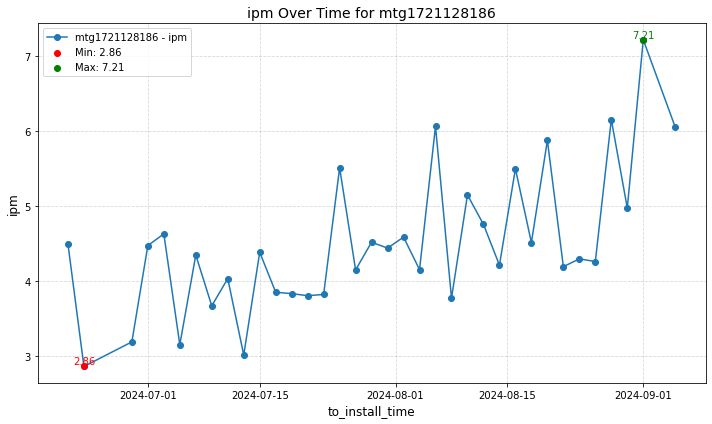

In [152]:
# Optional: Visualize the daily trend of a selected metric for a specific site

import matplotlib.pyplot as plt

# Define the site and metric to analyze
site_name = 'mtg1721128186'  # Specify the site
metric_name = 'ipm'  # Choose the metric to visualize

# Filter data for the selected site
site_data = df_sites_anomalies[df_sites_anomalies['site'] == site_name]

# Check if the filtered data is empty before proceeding
if site_data.empty:
    print(f"No data available for site: {site_name}")
else:
    # Identify the minimum and maximum values of the selected metric
    min_value = site_data[metric_name].min()
    max_value = site_data[metric_name].max()

    # Get corresponding timestamps for min and max values
    min_time = site_data.loc[site_data[metric_name].idxmin(), 'to_install_time']
    max_time = site_data.loc[site_data[metric_name].idxmax(), 'to_install_time']

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot the metric's trend over time
    plt.plot(site_data['to_install_time'], site_data[metric_name], marker='o', linestyle='-', 
             label=f'{site_name} - {metric_name}')

    # Highlight minimum and maximum points on the graph
    plt.scatter(min_time, min_value, color='red', label=f'Min: {min_value:.2f}', zorder=5)
    plt.scatter(max_time, max_value, color='green', label=f'Max: {max_value:.2f}', zorder=5)

    # Add text labels for min/max values
    plt.text(min_time, min_value, f'{min_value:.2f}', fontsize=10, color='red', ha='center', va='bottom')
    plt.text(max_time, max_value, f'{max_value:.2f}', fontsize=10, color='green', ha='center', va='bottom')

    # Configure plot labels and appearance
    plt.title(f'{metric_name} Over Time for {site_name}', fontsize=14)
    plt.xlabel('to_install_time', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.grid(visible=True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()

    # Display the plot
    plt.show()
